# BEM and CCBlade NB
## The Analysis of an APC 10 x 7 Thin Electric Propeller using blade element momentum through the CCBlade.jl package
## Jacob Child


### Background:
A propeller blade can be analyzed by breaking the blade up into sections, computing the desired results at each section, and then summing the results to obtain the overall blade characteristics. CCBlade.jl is a package that makes using this method within Julia very streamlined and easy.

### Method/Pseudocode:
We desire to analyze and APC 10 x 7 thin electric propeller found [here](https://www.apcprop.com/product/10x7e/). We will first define the rotor characteristics and geometry, and the compute and plot the desired coefficients at each radial section location. The data for this propeller can be found on the UIUC website [here](https://m-selig.ae.illinois.edu/props/volume-1/propDB-volume-1.html#APC) - Found under "Thin Electric" it is the "10 x 7  [1]" ctrl+f for that exactly and you will find it under apc thin electric. More experimental data (used later in this notebook) is found on the manufacturer's website [here](https://www.apcprop.com/files/PER3_10x7E.dat)

### Assumptions:
The APC website says that their thin electric propellers are typically a mix of the Eppler E63 Low Reynolds Number Propeller and a Clark-Y similar airfoil towards the tip. As the location and details of the transition and twist is not known, we will assume it is an Eppler E63 airfoil along the whole blade. Data for that is found [here](http://airfoiltools.com/airfoil/details?airfoil=e63-il)

**Needed Packages** <br>


In [3]:
#Packages
using CCBlade, PyPlot

**Define the rotor geometry and characteristics** <br>

In [4]:
#Define the Rotor
Rtip = 10/2 * .0254     #The tip radius is the diameter/2 and the converts in to meters
Rhub = .8/2 * .0254     #The hub radiaus is diameter/2 and can be found on the website
#Note: if not given on a website, look at the geometry file and the first point is r/R, or saying the current point 
# ... is 15% of the tip radius, so the hub has is less than that as the first point is on the blade itself and not the hub 
B = 2   #Number of blades
RPM = 5000.0  #The quick start guide uses 5400, but experimental data is only in 1000s on the website 

rotor = Rotor(Rhub, Rtip, B) #calls Rotor from the CCBlade package and stores a "Rotor" object
#fieldnames(typeof(rotor))

#Define the Prop geometry
#Taken from the UIUC database for this prop
#The first 2 columns are given in percent of Rtip (or Blade Tip Radius)

propgeom = [
0.15   0.138   37.86
0.20   0.154   45.82
0.25   0.175   44.19
0.30   0.190   38.35
0.35   0.198   33.64
0.40   0.202   29.90
0.45   0.200   27.02
0.50   0.195   24.67
0.55   0.186   22.62
0.60   0.174   20.88
0.65   0.161   19.36
0.70   0.145   17.98
0.75   0.129   16.74
0.80   0.112   15.79
0.85   0.096   14.64
0.90   0.081   13.86
0.95   0.061   12.72
1.00   0.040   11.53
]

r = propgeom[:, 1] * Rtip   #This gives the radial locations r in 5% steps along the blade
chord = propgeom[:, 2] * Rtip   #This gives the Chord length at each radial step/location 
theta = propgeom[:, 3] * pi/180     #the twist angle, converted from degrees to radians (what CCBlade wants)

emptyvar = "Ran" #this supresses the output of whatever was last put in and validates that the cell ran

"Ran"

**Airfoil Data** <br>
As discussed in the assumptions earlier, we are saying that it is an Eppler E63 airfoil applied across the whole blade. The data for this airfoil came from my ExtenderNSmoother code and is not corrected in any manner.

In [16]:
#Airfoil data
#Airfoil data needs to be imported, ie the lift and drag coef of the airfoil at each radial location
af = AlphaAF("EpplerE63Data.txt")   #this gives angle of attack, lift coefficient, drag coefficient
#... the top row has header info, then reynolds number, then mach number, on a dif row each

emptyvar = "Ran" #this supresses the output of whatever was last put in and validates that the cell ran

"Ran"

**Define the sections** <br>
The root of the Blade Element Momentum method is having each section to analyze. This will store the characteristics of each section, ie radial location, chord length, thetas to be analyzed, and the airfoil properties from above.

In [17]:
#Define sections to analyze
sections = Section.(r, chord, theta, Ref(af))   #the "." broadcasts to define all sections at once, and as the airfoil 
#... doesn't change af is wrapped in Ref to make it the same for each 
#fieldnames(typeof(sections[1]))

emptyvar = "Ran" #this supresses the output of whatever was last put in and validates that the cell ran

"Ran"

**Define Operating Points** <br>
This defines what the flow field conditions are at each section. Each "operating point" has the velocity components, density, pitch, mu (dynamic viscosity), and the speed of sound (for the Mach number I think?)

In [18]:
#Define the operating points 
#Define the input airflow and broadcast to solve the velocity at each point 
Vinf = 5.0  #inflow velocity
Omega = RPM*pi/30  #converts rpm to rad/s, derivation: rpm*pi*360deg/(60sec*180deg)-> rpm*pi/30
rho = 1.225     #density of the air in metric

op = simple_op.(Vinf, Omega, r, rho)    #calls simple_op to define "operating points" at each section
#fieldnames(typeof(op[1])) 

emptyvar = "Ran" #this supresses the output of whatever was last put in and validates that the cell ran

"Ran"

**Solve** <br>
With all the neccessary "elements" for BEM setup we can now solve using the solve function in the CCBlade package. What is output is a struct of results at each section/radial location. A list of all the struct outputs and definitions can be found [here](https://flow.byu.edu/CCBlade.jl/stable/reference/#Output-Struct)


In [19]:
out = solve.(Ref(rotor), sections, op)  #outputs a struct of results for each section/radial location

emptyvar = "Ran" #this supresses the output of whatever was last put in and validates that the cell ran

"Ran"

**Preparation for coefficient analysis and plotting** <br>
Efficiency, Coefficient of Thrust, and Coefficient of Torque, are functions of the coefficents found above (the formulas are shown below). Each of these values that relies on a velocity or rpm is thus also a function of the Advance Ratio, or the ratio of forward speed divided by rotational speed. We will create a range of advance ratios (almost like a range of velocities in other domains) in order to plot and analyze later <br>
*Efficiency*
$$ \eta = \frac{P_{out}}{P_{in}} = \frac{TV}{Q\Omega} $$
*Explanation-* eta = Power output over power input, or Thrust times Velocity over Torque times rotational speed <br><br>

*Coefficent of Thrust*
$$ C_T = \frac {T}{\rho n^2 D^4} $$
*Explanation-* T = Thrust, rho = density of the fluid, n = propeller rotation rate in revolutions per second, D = propeller diameter <br><br>

*Coeffcient of Torque*
$$ C_Q = \frac {Q}{\rho n^2 D^5} $$
*Explanation-* Q = Torque, rho = density of the fluid, n = propeller rotation rate in revolutions per second, D = propeller diameter <br><br>

*Advance Ratio*
$$ J = \frac{V}{nD}  $$
*Explanation-* J = Forward velocity divided by n = revolutions per second, D = Diameter <br>
*Add coef of power and explain derivation somewhere*


In [20]:
#Inputs
nJ = 20     #number of advance ratios to evaluate
J = range(0.0, 1.0, length = nJ) #creates a range of advance ratios from .1 to .6, what are normal vals?
Omega = RPM*pi/30  #rpms to rad/sec 
n = Omega/(2*pi)    # converts radians persecond to just rotations per second, same as rpm/60
D = 2 * Rtip    #Diameter of the prop is 2* the radius, do I ignore the hub?

eff = zeros(nJ)     #creates arrays for efficiency, coef of thrust, and coef of torque 
CT = zeros(nJ)
CQ = zeros(nJ)      #coef of torque is requried torque over theoretical required torque

emptyvar = "Ran" #this supresses the output of whatever was last put in and validates that the cell ran

"Ran"

**Solve for the coefficients** <br>
Each coefficient is going to be different at each advance ratio, and also at each section, or element, of the blade, so we will use a for loop to calculate all the needed values.

In [21]:
for i = 1:nJ
    local Vinf = J[i] * D * n   #makes a local inflow veloc var at each advance ratio 
    local op = simple_op.(Vinf, Omega, r, rho)  #creates op pts at each blade section/location
    
    outputs = solve.(Ref(rotor), sections, op) #uses all data from above plus local op conditions
    T, Q = thrusttorque(rotor, sections, outputs)   #calcs T & Q at each sec w/given conds, sums them for the whole rotor
    eff[i], CT[i], CQ[i] = nondim(T, Q, Vinf, Omega, rho, rotor, "propeller")
    # calcs the coef of the blade under the given conditions at each advance ratio
end

**Experimental Data to prepare to plot** <br>
Experimental data can be found both at the UIUC database and the APC database, I chose to go with the APC database as they are the manufacturer and also have more outputs should I desire to use them in the future. It can be found [here](https://www.apcprop.com/files/PER3_10x7E.dat) <br>
*Note:* This experimental data is specific to 5000 RPM (which is what I defined above), but data is available for other rpms.<br>
The data has the following heading structure <br>
V (mph) | J (Adv Ratio) | Pe (efficiency) | Ct | Cp | PWR (Hp) | Torque (In-Lbf) | Thrust (Lbf)


In [22]:
#Experimental data at the given Advance Ratio
#V (mph)|J(Adv Ratio)|Pe(efficiency)| --Ct--- | --Cp--- | PWR (Hp) | Torque (In-Lbf) | Thrust (Lbf)

exp = [
    0.0        0.00      0.0000      0.1161      0.0549       0.055       0.695       0.925              
    1.5        0.03      0.0657      0.1159      0.0559       0.056       0.708       0.923              
    3.0        0.06      0.1286      0.1157      0.0569       0.057       0.722       0.921              
    4.5        0.09      0.1888      0.1153      0.0580       0.058       0.735       0.918              
    6.0        0.13      0.2462      0.1149      0.0591       0.059       0.749       0.915              
    7.5        0.16      0.3008      0.1143      0.0601       0.060       0.762       0.910              
    9.0        0.19      0.3527      0.1133      0.0610       0.061       0.774       0.902              
   10.5        0.22      0.4018      0.1119      0.0617       0.062       0.782       0.891              
   12.0        0.25      0.4481      0.1100      0.0622       0.063       0.788       0.876              
   13.5        0.28      0.4915      0.1077      0.0624       0.063       0.791       0.858              
   15.0        0.32      0.5318      0.1050      0.0625       0.063       0.792       0.836              
   16.5        0.35      0.5691      0.1018      0.0623       0.063       0.790       0.811              
   18.0        0.38      0.6033      0.0983      0.0619       0.062       0.785       0.783              
   19.5        0.41      0.6343      0.0945      0.0613       0.062       0.777       0.752              
   21.0        0.44      0.6620      0.0902      0.0604       0.061       0.765       0.718              
   22.5        0.47      0.6864      0.0855      0.0591       0.059       0.750       0.681              
   24.0        0.51      0.7076      0.0803      0.0575       0.058       0.729       0.640              
   25.5        0.54      0.7256      0.0749      0.0556       0.056       0.704       0.597              
   27.0        0.57      0.7406      0.0694      0.0534       0.054       0.677       0.553              
   28.5        0.60      0.7526      0.0637      0.0509       0.051       0.646       0.508              
   30.0        0.63      0.7624      0.0580      0.0482       0.048       0.610       0.462              
   31.5        0.66      0.7701      0.0521      0.0450       0.045       0.570       0.415              
   33.0        0.70      0.7755      0.0460      0.0413       0.042       0.524       0.366              
   34.5        0.73      0.7781      0.0398      0.0372       0.037       0.472       0.317              
   36.0        0.76      0.7773      0.0334      0.0327       0.033       0.414       0.266              
   37.5        0.79      0.7694      0.0269      0.0277       0.028       0.351       0.214              
   39.0        0.82      0.7468      0.0203      0.0224       0.023       0.284       0.162              
   40.5        0.85      0.6956      0.0136      0.0167       0.017       0.212       0.108              
   42.0        0.89      0.5648      0.0068      0.0107       0.011       0.136       0.054              
   43.5        0.92      0.0024      0.0000      0.0047       0.005       0.059       0.000 
]  

#Experimental value extraction
JExp = exp[:,2]     #Advanced ratio
CtExp = exp[:, 4] #Coef of Thrust
CpExp = exp[:, 5] #Coef of Power
EtaExp = exp[:, 3] #Efficiency

emptyvar = "Ran" #this supresses the output of whatever was last put in and validates that the cell ran

"Ran"

**Plotting and Data Comparison** <br>
Convention will be followed with the figure caption below the plot. The discussion will also be below the given plot, this means in turn that the code for each plot will have to be above it.

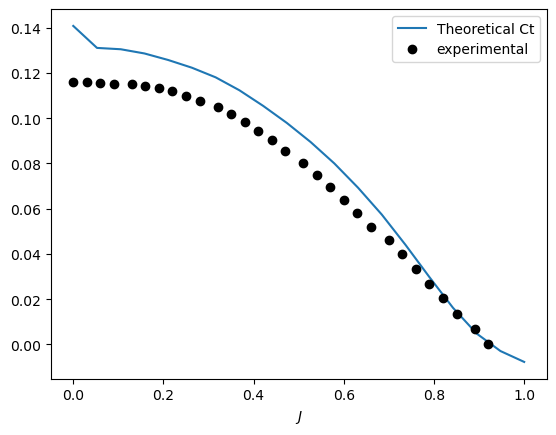

"Ran"

In [23]:
figure(1)
plot(J, CT)
plot(JExp, CtExp, "ko")
xlabel(L"J")
legend(["Theoretical Ct", "experimental"])

emptyvar = "Ran" #this supresses the output of whatever was last put in and validates that the cell ran

*Figure 1:* Experimental and theoretical coefficients of thrust plotted at different advance ratios <br><br>
**Discussion** <br>


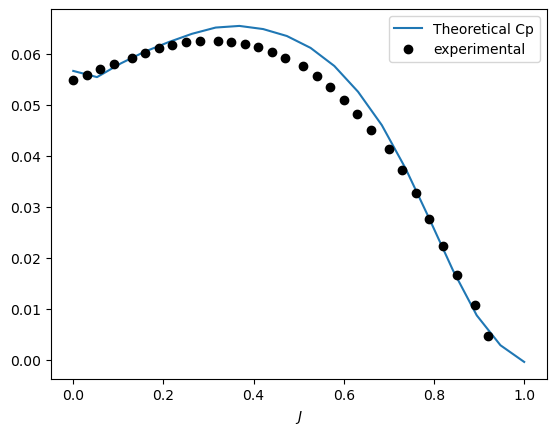

"Ran"

In [24]:
figure(2)
plot(J, CQ*2*pi)
plot(JExp, CpExp, "ko")
xlabel(L"J")
legend(["Theoretical Cp", "experimental"])

emptyvar = "Ran" #this supresses the output of whatever was last put in and validates that the cell ran

*Figure 2:* Experimental and theoretical coefficients of power plotted at different advance ratios <br><br>
**Discussion** <br>
My over simplification of using a NACA 4412 underperforms compared to the airfoil cross sections that were actually used! Interesting!

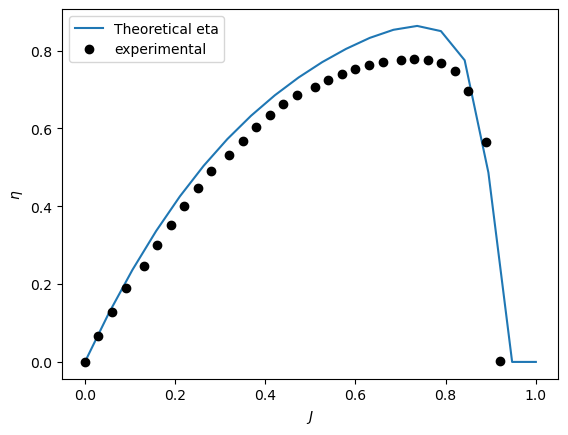

"Ran"

In [25]:
figure(3)
plot(J, eff)
plot(JExp, EtaExp, "ko")
xlabel(L"J")
ylabel(L"\eta")
legend(["Theoretical eta", "experimental"])

emptyvar = "Ran" #this supresses the output of whatever was last put in and validates that the cell ran

*Figure 3:* Experimental and theoretical efficiencies plotted at different advance ratios <br><br>
**Discussion**
Looks to be about the same peak value, just at a different advance ratio